In [21]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import math
import pickle
from tqdm import tqdm

from graspy.plot import heatmap
from graspy.utils import is_symmetric, symmetrize

from mgcpy.independence_tests.dcorr import DCorr
from mgcpy.independence_tests.rv_corr import RVCorr
from mgcpy.independence_tests.mgc.mgc import MGC

from simulations import rho_sbm_marg, rho_ER_marg, sbm_marg_corr_diff
from utils import sbm_params, triu_no_diag, to_distance_mtx, identity, permute_off_diag, permute_on_diag, block_permute

### rho-ER permutation

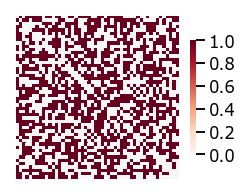

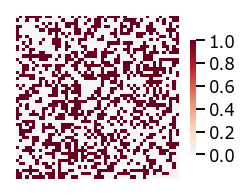

In [2]:
rho = 0.8
n = 50
A, B = rho_ER_marg(rho=rho, p=0.5, q=0.4, n=n)
heatmap(A, figsize=(4,3))
heatmap(B, figsize=(4,3))

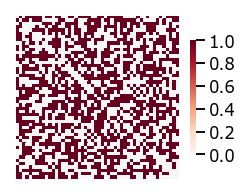

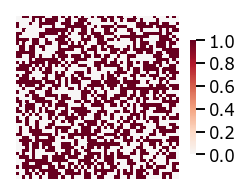

In [3]:
heatmap(A, figsize=(4,3))
heatmap(permute_on_diag(A), figsize=(4,3))

### rho-SBM permutation

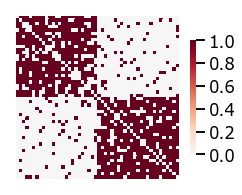

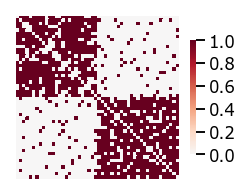

In [4]:
rho = 0.8
n = 50
k = 2
A, B = rho_sbm_marg(rho=rho, k=k, AL=sbm_params(a=0.8, b=0.1), BL=sbm_params(a=0.8, b=0.1), n=n)
heatmap(A, figsize=(4,3))
heatmap(B, figsize=(4,3))

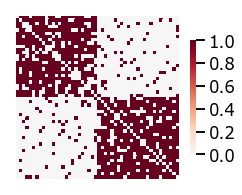

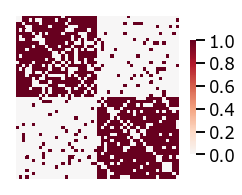

In [5]:
heatmap(A, figsize=(4,3))
heatmap(block_permute(A, np.repeat([0, 1], n//k)), figsize=(4,3))

In [6]:
is_symmetric(A)

True

In [7]:
is_symmetric(block_permute(A, np.repeat([0, 1], n//k)))

True

In [8]:
def rho_er_power(indept_test, transform_func, rho, p, q, n=50, mc=500, alpha=0.05):
    test_stat_null_array = np.zeros(mc)
    test_stat_alt_array = np.zeros(mc)
    for i in range(mc):
        A, B = rho_ER_marg(rho, p, q, n)
        test_stat_alt, _ = indept_test.test_statistic(
            matrix_X=transform_func(A), matrix_Y=transform_func(B))
        test_stat_alt_array[i] = test_stat_alt

        # generate the null by permutation
        A_null = permute_on_diag(A)
        test_stat_null, _ = indept_test.test_statistic(
            matrix_X=transform_func(A_null), matrix_Y=transform_func(B))
        test_stat_null_array[i] = test_stat_null
    # if pearson, use the absolute value of test statistic then use one-sided
    # rejection region
    if indept_test.get_name() == 'pearson':
        test_stat_null_array = np.absolute(test_stat_null_array)
        test_stat_alt_array = np.absolute(test_stat_alt_array)
    critical_value = np.sort(test_stat_null_array)[math.ceil((1-alpha)*mc)]
    power = np.where(test_stat_alt_array > critical_value)[0].shape[0] / mc
    return power

In [12]:
def rho_sbm_given_block_power(indept_test, transform_func, rho, P1, P2, k=2, n=50, mc=500, alpha=0.05):
    test_stat_null_array = np.zeros(mc)
    test_stat_alt_array = np.zeros(mc)
    for i in range(mc):
        A, B = rho_sbm_marg(rho, k, P1, P2, n)
        test_stat_alt, _ = indept_test.test_statistic(
            matrix_X=transform_func(A), matrix_Y=transform_func(B))
        test_stat_alt_array[i] = test_stat_alt

        # generate the null by permutation
        block_assignment = np.repeat(np.arange(k), n//k)
        A_null = block_permute(A, block_assignment)
        test_stat_null, _ = indept_test.test_statistic(
            matrix_X=transform_func(A_null), matrix_Y=transform_func(B))
        test_stat_null_array[i] = test_stat_null
    # if pearson, use the absolute value of test statistic then use one-sided
    # rejection region
    if indept_test.get_name() == 'pearson':
        test_stat_null_array = np.absolute(test_stat_null_array)
        test_stat_alt_array = np.absolute(test_stat_alt_array)
    critical_value = np.sort(test_stat_null_array)[math.ceil((1-alpha)*mc)]
    power = np.where(test_stat_alt_array > critical_value)[0].shape[0] / mc
    return power

In [13]:
n_arr = np.linspace(10, 100, 10, dtype=int)
nmc = 1000
rho_arr = np.array([0.1])
P = sbm_params(a=0.7, b=0.3)
test_names = ['pearson', 'dcorr', 'mgc']
power_sbm = {
    'pearson': np.zeros((rho_arr.shape[0], n_arr.shape[0])),
    'dcorr': np.zeros((rho_arr.shape[0], n_arr.shape[0])),
    'mgc': np.zeros((rho_arr.shape[0], n_arr.shape[0]))
}

for i, rho in enumerate(rho_arr):
    for j, n in enumerate(n_arr):
        for name in test_names:
            if name == 'pearson':
                test = RVCorr(which_test='pearson')
                test_power = rho_sbm_given_block_power(test, triu_no_diag, rho=rho, P1=P, P2=P, k=2, n=n, mc=nmc)
            elif name == 'dcorr':
                test = DCorr(compute_distance_matrix=identity)
                test_power = rho_sbm_given_block_power(test, to_distance_mtx, rho=rho, P1=P, P2=P, k=2, n=n, mc=nmc)
            elif name == 'mgc':
                test = MGC(compute_distance_matrix=identity)
                test_power = rho_sbm_given_block_power(test, to_distance_mtx, rho=rho, P1=P, P2=P, k=2, n=n, mc=nmc)
            power_sbm[name][i, j] = test_power
            print('finish {} for rho={}, n={}: power={}'.format(name, rho, n, test_power))

finish pearson for rho=0, n=10: power=0.05
finish dcorr for rho=0, n=10: power=0.054
finish mgc for rho=0, n=10: power=0.051
finish pearson for rho=0, n=20: power=0.053
finish dcorr for rho=0, n=20: power=0.048
finish mgc for rho=0, n=20: power=0.045
finish pearson for rho=0, n=30: power=0.04
finish dcorr for rho=0, n=30: power=0.053
finish mgc for rho=0, n=30: power=0.078
finish pearson for rho=0, n=40: power=0.06
finish dcorr for rho=0, n=40: power=0.046
finish mgc for rho=0, n=40: power=0.048
finish pearson for rho=0, n=50: power=0.049
finish dcorr for rho=0, n=50: power=0.045
finish mgc for rho=0, n=50: power=0.046
finish pearson for rho=0, n=60: power=0.044
finish dcorr for rho=0, n=60: power=0.036
finish mgc for rho=0, n=60: power=0.046
finish pearson for rho=0, n=70: power=0.048
finish dcorr for rho=0, n=70: power=0.059
finish mgc for rho=0, n=70: power=0.046
finish pearson for rho=0, n=80: power=0.027
finish dcorr for rho=0, n=80: power=0.066
finish mgc for rho=0, n=80: power=0

In [15]:
power_sbm

{'pearson': array([[0.05 , 0.053, 0.04 , 0.06 , 0.049, 0.044, 0.048, 0.027, 0.065,
         0.05 ]]),
 'dcorr': array([[0.054, 0.048, 0.053, 0.046, 0.045, 0.036, 0.059, 0.066, 0.048,
         0.055]]),
 'mgc': array([[0.051, 0.045, 0.078, 0.048, 0.046, 0.046, 0.046, 0.054, 0.064,
         0.047]])}

In [16]:
with open ('../results/rho_sbm_power_null.pkl', 'wb') as f:
    pickle.dump(power_sbm, f)

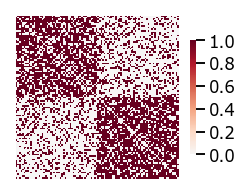

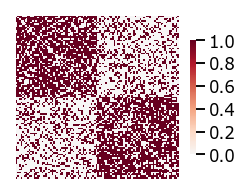

In [21]:
A, B = rho_sbm_marg(rho=0.0, k=2, AL=sbm_params(a=0.7, b=0.3), BL=sbm_params(a=0.7, b=0.3), n=n)
heatmap(A, figsize=(4,3))
heatmap(B, figsize=(4,3))

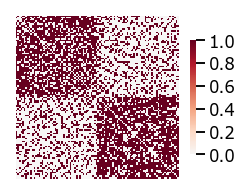

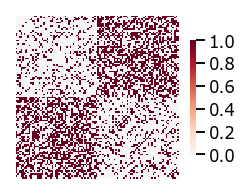

In [22]:
A, B = rho_sbm_marg(rho=0.3, k=2, AL=sbm_params(a=0.7, b=0.3), BL=sbm_params(a=0.2, b=0.5), n=n)
heatmap(A, figsize=(4,3))
heatmap(B, figsize=(4,3))

In [17]:
n_arr = np.linspace(10, 100, 10, dtype=int)
rho_arr = np.array([0])
P1 = sbm_params(a=0.7, b=0.3)
P2 = sbm_params(a=0.2, b=0.5)
nmc = 1000
test_names = ['pearson', 'dcorr', 'mgc']
power_sbm_marg = {
    'pearson': np.zeros((rho_arr.shape[0], n_arr.shape[0])),
    'dcorr': np.zeros((rho_arr.shape[0], n_arr.shape[0])),
    'mgc': np.zeros((rho_arr.shape[0], n_arr.shape[0]))
}

for name in test_names:
    for i, rho in enumerate(rho_arr):
        for j, n in enumerate(n_arr):
            if name == 'pearson':
                test = RVCorr(which_test='pearson')
                test_power = rho_sbm_given_block_power(test, triu_no_diag, rho=rho, P1=P1, P2=P2, k=2, n=n, mc=nmc)
            elif name == 'dcorr':
                test = DCorr(compute_distance_matrix=identity)
                test_power = rho_sbm_given_block_power(test, to_distance_mtx, rho=rho, P1=P1, P2=P2, k=2, n=n, mc=nmc)
            elif name == 'mgc':
                test = MGC(compute_distance_matrix=identity)
                test_power = rho_sbm_given_block_power(test, to_distance_mtx, rho=rho, P1=P1, P2=P2, k=2, n=n, mc=nmc)
            power_sbm_marg[name][i, j] = test_power
            print('finish {} for rho={}, n={}'.format(name, rho, n))

finish pearson for rho=0, n=10
finish pearson for rho=0, n=20
finish pearson for rho=0, n=30
finish pearson for rho=0, n=40
finish pearson for rho=0, n=50
finish pearson for rho=0, n=60
finish pearson for rho=0, n=70
finish pearson for rho=0, n=80
finish pearson for rho=0, n=90
finish pearson for rho=0, n=100
finish dcorr for rho=0, n=10
finish dcorr for rho=0, n=20
finish dcorr for rho=0, n=30
finish dcorr for rho=0, n=40
finish dcorr for rho=0, n=50
finish dcorr for rho=0, n=60
finish dcorr for rho=0, n=70
finish dcorr for rho=0, n=80
finish dcorr for rho=0, n=90
finish dcorr for rho=0, n=100
finish mgc for rho=0, n=10
finish mgc for rho=0, n=20
finish mgc for rho=0, n=30
finish mgc for rho=0, n=40
finish mgc for rho=0, n=50
finish mgc for rho=0, n=60
finish mgc for rho=0, n=70
finish mgc for rho=0, n=80
finish mgc for rho=0, n=90
finish mgc for rho=0, n=100


In [19]:
power_sbm_marg

{'pearson': array([[0.045, 0.064, 0.036, 0.038, 0.041, 0.039, 0.038, 0.061, 0.056,
         0.062]]),
 'dcorr': array([[0.06 , 0.037, 0.062, 0.053, 0.066, 0.046, 0.044, 0.069, 0.04 ,
         0.047]]),
 'mgc': array([[0.08 , 0.047, 0.036, 0.034, 0.05 , 0.047, 0.053, 0.066, 0.051,
         0.05 ]])}

In [20]:
with open ('../results/rho_sbm_marg_power_null.pkl', 'wb') as f:
    pickle.dump(power_sbm_marg, f)

In [9]:
n_arr = np.linspace(10, 100, 10, dtype=int)
rho_arr = np.array([0])
nmc = 1000
test_names = ['pearson', 'dcorr', 'mgc']
power_rho_er = {
    'pearson': np.zeros((rho_arr.shape[0], n_arr.shape[0])),
    'dcorr': np.zeros((rho_arr.shape[0], n_arr.shape[0])),
    'mgc': np.zeros((rho_arr.shape[0], n_arr.shape[0]))
}

for name in test_names:
    for i, rho in enumerate(rho_arr):
        for j, n in enumerate(n_arr):
            if name == 'pearson':
                test = RVCorr(which_test='pearson')
                test_power = rho_er_power(test, triu_no_diag, rho=rho, p=0.5, q=0.5, n=n, mc=nmc)
            elif name == 'dcorr':
                test = DCorr(compute_distance_matrix=identity)
                test_power = rho_er_power(test, to_distance_mtx, rho=rho, p=0.5, q=0.5, n=n, mc=nmc)
            elif name == 'mgc':
                test = MGC(compute_distance_matrix=identity)
                test_power = rho_er_power(test, to_distance_mtx, rho=rho, p=0.5, q=0.5, n=n, mc=nmc)
            power_rho_er[name][i, j] = test_power
            print('finish {} for rho={}, n={}'.format(name, rho, n))

finish pearson for rho=0, n=10
finish pearson for rho=0, n=20
finish pearson for rho=0, n=30
finish pearson for rho=0, n=40
finish pearson for rho=0, n=50
finish pearson for rho=0, n=60
finish pearson for rho=0, n=70
finish pearson for rho=0, n=80
finish pearson for rho=0, n=90
finish pearson for rho=0, n=100
finish dcorr for rho=0, n=10
finish dcorr for rho=0, n=20
finish dcorr for rho=0, n=30
finish dcorr for rho=0, n=40
finish dcorr for rho=0, n=50
finish dcorr for rho=0, n=60
finish dcorr for rho=0, n=70
finish dcorr for rho=0, n=80
finish dcorr for rho=0, n=90
finish dcorr for rho=0, n=100
finish mgc for rho=0, n=10
finish mgc for rho=0, n=20
finish mgc for rho=0, n=30
finish mgc for rho=0, n=40
finish mgc for rho=0, n=50
finish mgc for rho=0, n=60
finish mgc for rho=0, n=70
finish mgc for rho=0, n=80
finish mgc for rho=0, n=90
finish mgc for rho=0, n=100


In [10]:
power_rho_er

{'pearson': array([[0.045, 0.048, 0.047, 0.044, 0.058, 0.052, 0.044, 0.05 , 0.044,
         0.036]]),
 'dcorr': array([[0.086, 0.053, 0.055, 0.04 , 0.058, 0.052, 0.048, 0.053, 0.051,
         0.043]]),
 'mgc': array([[0.037, 0.053, 0.044, 0.052, 0.044, 0.049, 0.056, 0.034, 0.045,
         0.037]])}

In [11]:
with open ('../results/rho_er_power_null.pkl', 'wb') as f:
    pickle.dump(power_rho_er, f)

In [40]:
n_arr = np.linspace(10, 100, 10, dtype=int)
rho_arr = np.array([0, 0.1])
test_names = ['pearson', 'dcorr', 'mgc']
power_rho_er_marg = {
    'pearson': np.zeros((rho_arr.shape[0], n_arr.shape[0])),
    'dcorr': np.zeros((rho_arr.shape[0], n_arr.shape[0])),
    'mgc': np.zeros((rho_arr.shape[0], n_arr.shape[0]))
}

for name in test_names:
    for i, rho in enumerate(rho_arr):
        for j, n in enumerate(n_arr):
            if name == 'pearson':
                test = RVCorr(which_test='pearson')
                test_power = rho_er_power(test, triu_no_diag, rho=rho, p=0.7, q=0.2, n=n)
            elif name == 'dcorr':
                test = DCorr(compute_distance_matrix=identity)
                test_power = rho_er_power(test, to_distance_mtx, rho=rho, p=0.7, q=0.2, n=n)
            elif name == 'mgc':
                test = MGC(compute_distance_matrix=identity)
                test_power = rho_er_power(test, to_distance_mtx, rho=rho, p=0.7, q=0.2, n=n)
            power_rho_er_marg[name][i, j] = test_power
            print('finish {} for rho={}, n={}'.format(name, rho, n))

finish pearson for rho=0.0, n=10
finish pearson for rho=0.0, n=20
finish pearson for rho=0.0, n=30
finish pearson for rho=0.0, n=40
finish pearson for rho=0.0, n=50
finish pearson for rho=0.0, n=60
finish pearson for rho=0.0, n=70
finish pearson for rho=0.0, n=80
finish pearson for rho=0.0, n=90
finish pearson for rho=0.0, n=100
finish pearson for rho=0.1, n=10
finish pearson for rho=0.1, n=20
finish pearson for rho=0.1, n=30
finish pearson for rho=0.1, n=40
finish pearson for rho=0.1, n=50
finish pearson for rho=0.1, n=60
finish pearson for rho=0.1, n=70
finish pearson for rho=0.1, n=80
finish pearson for rho=0.1, n=90
finish pearson for rho=0.1, n=100
finish dcorr for rho=0.0, n=10
finish dcorr for rho=0.0, n=20
finish dcorr for rho=0.0, n=30
finish dcorr for rho=0.0, n=40
finish dcorr for rho=0.0, n=50
finish dcorr for rho=0.0, n=60
finish dcorr for rho=0.0, n=70
finish dcorr for rho=0.0, n=80
finish dcorr for rho=0.0, n=90
finish dcorr for rho=0.0, n=100
finish dcorr for rho=0.1, n

In [41]:
power_rho_er_marg

{'pearson': array([[0.044, 0.072, 0.044, 0.038, 0.04 , 0.06 , 0.04 , 0.046, 0.03 ,
         0.046],
        [0.078, 0.276, 0.46 , 0.832, 0.946, 0.978, 1.   , 1.   , 1.   ,
         1.   ]]),
 'dcorr': array([[0.066, 0.044, 0.046, 0.024, 0.044, 0.042, 0.054, 0.072, 0.06 ,
         0.05 ],
        [0.158, 0.38 , 0.814, 0.868, 0.962, 0.998, 0.998, 1.   , 1.   ,
         1.   ]]),
 'mgc': array([[0.024, 0.034, 0.03 , 0.038, 0.094, 0.042, 0.032, 0.044, 0.036,
         0.05 ],
        [0.14 , 0.416, 0.606, 0.906, 0.982, 0.998, 1.   , 1.   , 1.   ,
         1.   ]])}

In [42]:
with open ('../results/rho_er_marg_power.pkl', 'wb') as f:
    pickle.dump(power_rho_er_marg, f)